<a href="https://colab.research.google.com/github/teamvictory1/fullstack-nanodegree-vm/blob/master/Fellowship_ai_ULMFiT_submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fellowship.ai challenge

This is my submission to Fellowship.ai challenge of implementing ULMFiT model to the Twitter Airline Sentiment dataset. The dataset can be found [here](https://www.kaggle.com/crowdflower/twitter-airline-sentiment#Tweets.csv).

The aim of the challenge is to identify the sentiment of each tweet within the dataset. These tweets may express negative, positive or neutral emotion from the customers to the airline service. After analysing data, a model would be built from ULMFiT model, which is from [fast.ai](https://forums.fast.ai/t/part-2-lesson-10-wiki/14364).

** 1. Importing the required package for analysis and building model **

In [1]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
pymc3 3.6 has requirement joblib<0.13.0, but you'll have joblib 0.13.2 which is incompatible.
featuretools 0.4.1 has requirement pandas>=0.23.0, but you'll have pandas 0.22.0 which is incompatible.
albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.8 which is incompatible.
Done.


In [0]:
import numpy as np
import pandas as pd
from fastai.text import *
import html
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
import sklearn
from sklearn.model_selection import train_test_split
from fastai import *
%matplotlib inline 

** 2. Dataset Analysis **

    a. Importing dataset and getting summary of the dataset

In [4]:
tweet = pd.read_csv('Tweets.csv')
tweet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9155 entries, 0 to 9154
Data columns (total 15 columns):
tweet_id                        9155 non-null int64
airline_sentiment               9155 non-null object
airline_sentiment_confidence    9155 non-null float64
negativereason                  5084 non-null object
negativereason_confidence       6007 non-null float64
airline                         9155 non-null object
airline_sentiment_gold          21 non-null object
name                            9155 non-null object
negativereason_gold             17 non-null object
retweet_count                   9155 non-null int64
text                            9155 non-null object
tweet_coord                     689 non-null object
tweet_created                   9154 non-null object
tweet_location                  6310 non-null object
user_timezone                   6298 non-null object
dtypes: float64(2), int64(2), object(11)
memory usage: 1.0+ MB


With the summary, the dataset shows 14640 records with 15 columns. For the aim of this challenge, data from airline_sentiment, negativereason, airline, text are analysed to provide insight to the whole dataset

b. Dataset preview

In [5]:
tweet.head(10)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
5,570300767074181121,negative,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada)
6,570300616901320704,positive,0.6745,NaN,0.0000,Virgin America,NaN,cjmcginnis,NaN,0,"@VirginAmerica yes, nearly every time I fly VX...",NaN,2015-02-24 11:13:57 -0800,San Francisco CA,Pacific Time (US & Canada)
7,570300248553349120,neutral,0.6340,NaN,NaN,Virgin America,NaN,pilot,NaN,0,@VirginAmerica Really missed a prime opportuni...,NaN,2015-02-24 11:12:29 -0800,Los Angeles,Pacific Time (US & Canada)
8,570299953286942721,positive,0.6559,NaN,NaN,Virgin America,NaN,dhepburn,NaN,0,"@virginamerica Well, I didn't…but NOW I DO! :-D",NaN,2015-02-24 11:11:19 -0800,San Diego,Pacific Time (US & Canada)
9,570295459631263746,positive,1.0000,NaN,NaN,Virgin America,NaN,YupitsTate,NaN,0,"@VirginAmerica it was amazing, and arrived an ...",NaN,2015-02-24 10:53:27 -0800,Los Angeles,Eastern Time (US & Canada)


Counting number of tweet for each airline (United, US Airways, American, Southwest, Delta, Virgin America)

In [6]:
tweet.airline.value_counts()

United            3822
Southwest         2420
Delta             2220
Virgin America     504
US Airways         189
Name: airline, dtype: int64

Counting values for mood

In [7]:
mood_count = tweet.airline_sentiment.value_counts()
print(mood_count)

negative    5084
neutral     2295
positive    1776
Name: airline_sentiment, dtype: int64


Plotting mood

Text(0.5, 1.0, 'Count of Moods')

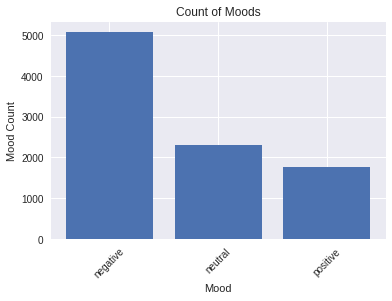

In [8]:
index = [1,2,3]
plt.bar(index, mood_count)
plt.xticks(index,['negative','neutral','positive'],rotation=45)
plt.ylabel('Mood Count')
plt.xlabel('Mood')
plt.title('Count of Moods')

Plotting mood according to each airline

In [0]:
def plot_airline_mood(airline):
    selected_airline = tweet[tweet['airline'] == airline]
    airline_sentiment_count = selected_airline['airline_sentiment'].value_counts()
    n_index = [1,2,3]
    plt.bar(n_index, airline_sentiment_count)
    plt.xticks(n_index,['Negative', 'Neutral', 'Positive'])
    plt.title('Sentiment Summary of' + " " + airline)
    
airline_name = tweet['airline'].unique()
plt.figure(1, figsize=(12,12))
for i in range(6):
    plt.subplot(3,3,i+1)
    plot_airline_mood(airline_name[i])

Counting negative feedback

In [14]:
ng_count = tweet.negativereason.value_counts()
print(ng_count)

Customer Service Issue         1382
Late Flight                     982
Can't Tell                      763
Lost Luggage                    437
Cancelled Flight                418
Bad Flight                      392
Flight Booking Problems         285
Flight Attendant Complaints     277
longlines                        97
Damaged Luggage                  51
Name: negativereason, dtype: int64


Ploting negative reason

Text(0, 0.5, 'No. of Tweets')

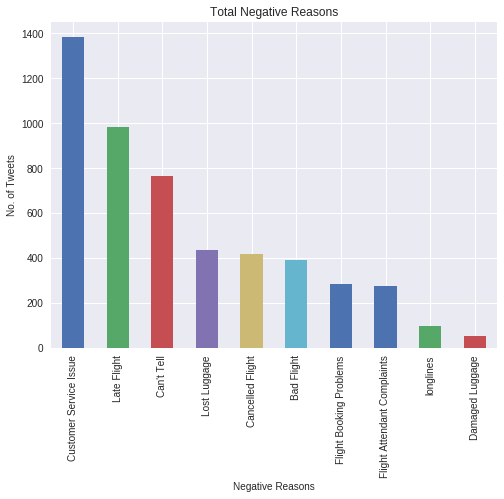

In [15]:
neg_index = [1,2,3,4,5,6,7,8,9,10]
neg_reason = tweet['negativereason'].unique()
neg_reason = neg_reason[~pd.isnull(neg_reason)]
pd.Series(tweet["negativereason"]).value_counts().plot(kind = "bar"
                        ,figsize=(8,6),title = "Total Negative Reasons")
plt.xlabel('Negative Reasons', fontsize=10)
plt.ylabel('No. of Tweets', fontsize=10)

Ploting negative reason for each airline

In [0]:
def plot_airline_negativereason(airline):
    selected_airline = tweet[tweet['airline'] == airline]
    airline_negativereason_count = selected_airline['negativereason'].value_counts()
    plt.bar(neg_index, airline_negativereason_count)
    plt.xticks(neg_index,neg_reason,rotation=90)
    plt.title('Negative Reason for' + " " + airline)

airline_name = tweet['airline'].unique()
plt.figure(1, figsize=(12,12))
for i in range(6):
    plt.subplot(3,2,i+1)
    plot_airline_negativereason(airline_name[i])

Wordcloud for negative tweet

In [0]:
from wordcloud import WordCloud, STOPWORDS

Negative wordcloud visualisation

In [0]:
df_neg = tweet[tweet['airline_sentiment'] == 'negative']
words = ' '.join(df_neg['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

In [0]:
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)

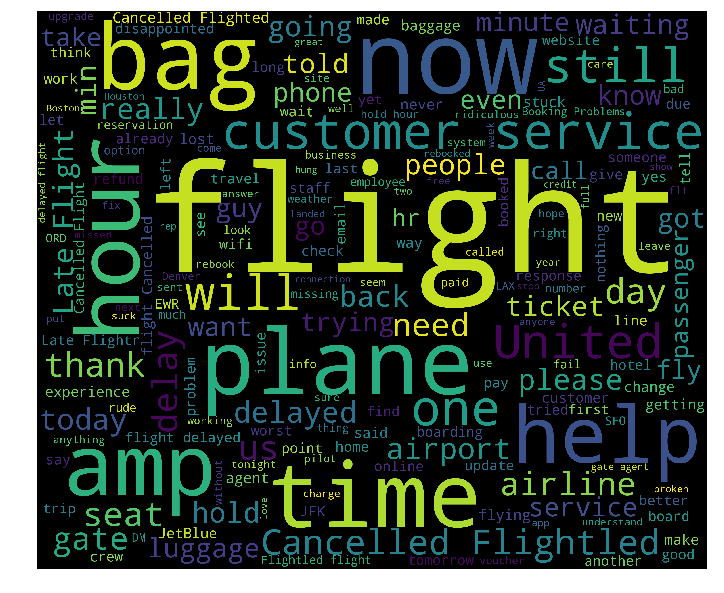

In [21]:
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Positive wordcloud visualisation

In [0]:
df_pos = tweet[tweet['airline_sentiment'] == 'positive']
words = ' '.join(df_pos['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

In [0]:
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)

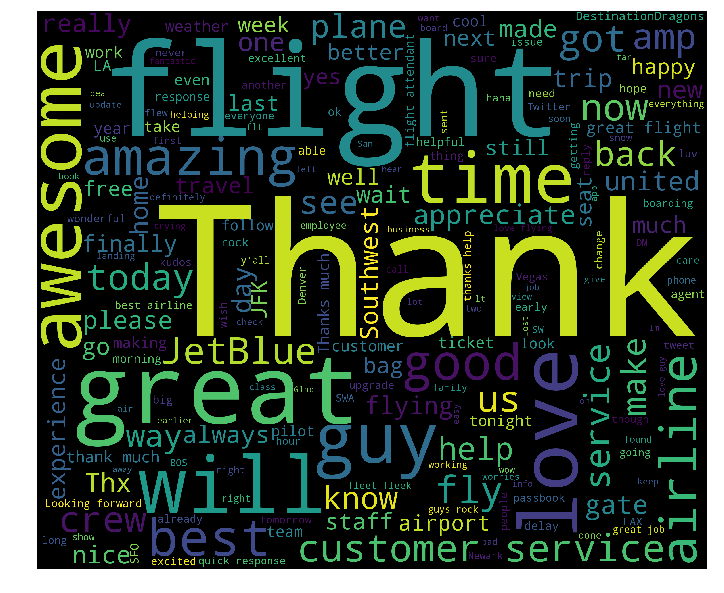

In [24]:
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Neutral wordcloud visualisation

In [0]:
df_neutral = tweet[tweet['airline_sentiment'] == 'neutral']
words = ' '.join(df_neutral['text'])
cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and word != 'RT'
                            ])

In [0]:
wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)

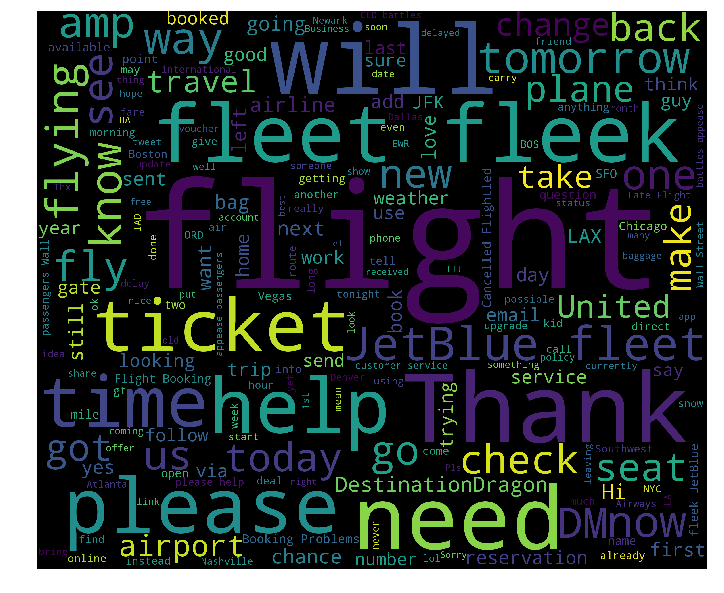

In [27]:
plt.figure(1,figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

** 3. Setting up the dataset for training model **

In [0]:
CLAS_PATH = Path('twitter_clas/')
CLAS_PATH.mkdir(exist_ok=True)

LM_PATH = Path('twitter_lm/')
LM_PATH.mkdir(exist_ok=True)

In [0]:
def sent_class(df):
    df['sentiment'] = df['airline_sentiment'].apply(lambda x:0 if x=='negative' else(1 if x=='positive' else 2))
    return df

In [0]:
df_tweets = sent_class(tweet)

Getting train and test set

In [0]:
def train_test_set(df,t_size,r_d):
    train_set, test_set = train_test_split(df,test_size=t_size,random_state=r_d)
    return train_set, test_set

In [0]:
df_train = train_test_set(df_tweets,0.1,42)[0]
df_test = train_test_set(df_tweets,0.1,42)[1]

Getting texts

In [0]:
def get_texts(df):
    texts,labels = [],[]
    for index, row in df.iterrows():
        texts.append(row['text'])
        labels.append(row['sentiment'])
    return np.array(texts), np.array(labels)

In [0]:
train_tweet, train_label = get_texts(df_train)
test_tweet, test_label = get_texts(df_test)

Random permutation to shuffle text

In [0]:
np.random.seed(42)
trn_idx = np.random.permutation(len(train_tweet))
test_idx = np.random.permutation(len(test_tweet))

In [0]:
train_tweet = train_tweet[trn_idx]
train_label = train_label[trn_idx]

test_tweet = test_tweet[test_idx]
test_label = test_label[test_idx]

In [0]:
col_names = ['labels','text']
df_trn = pd.DataFrame({'text':train_tweet,'labels':train_label},columns=col_names)
df_tst = pd.DataFrame({'text':test_tweet,'labels':test_label},columns=col_names)

Save train and test set to twitter_clas

In [0]:
CLASSES = ['negative','positive','neutral']
df_trn.to_csv(CLAS_PATH/'train.csv', header=False, index=False)
df_tst.to_csv(CLAS_PATH/'test.csv', header=False, index=False)

(CLAS_PATH/'classes.txt').open('w', encoding='utf-8').writelines(f'{o}\n' for o in CLASSES)

<h3> ULMFiT </h3>

ULMFiT is a recent development with Natural Language Processing. It uses the principle of transfer learning to facilitate training models that deal with language. The model uses mechanisim of model back-bone and classifier head.

The model back-bone can be regarded as a pre-trained language model. With fast.ai pretrained language model with the wikitext dataset, the back-bone of the model is fine-tunned for this particular twitter dataset. Since training from scratch a comprehenssive language model is very resource expensive, fine-tunning a pre-trained model can be a better alternative.

The classifier head is then added to perform multiclass classification.

![ULMFiT image](https://cdn-images-1.medium.com/max/2000/1*w_qNXVr7N2OPCK5iMnHAVQ.png)

The training process consists of three steps:
    1. Developing and training the language model. The pre-trained model will be imported and gradually unfreeze layers for fine tunning.
    2. Importing the classifier and fine-tunning the classifier head according to the dataset
    3. Train the model and validate it's accuracy.

** 4. Developing and Training the Language model. Fast.ai has provided API to use ULMFiT **

In [0]:
data_lm = TextLMDataBunch.from_csv(CLAS_PATH, 'train.csv', min_freq=1)

In [0]:
data_lm.save()

In [41]:
data_lm.show_batch()

idx,text
0,"true ? xxbos @usairways xxmaj waiting on my flight right now , thanks ! ! xxbos @united - rebooked to xxup oma - 180 miles from my destination . xxmaj spotty customer service . i get staff stressors but come on , this is your business . xxbos @jetblue you are missing the point . xxmaj the flight left an hour xxmaj late xxmaj flight . xxmaj why are you"
1,! i have a job to get2 xxbos @southwestair i 've been on hold almost an hour ! i xxup luv y' all but # imjustsaying 😔 😔 😔 http : / / t.co / t6fyybhjhl xxbos @southwestair can take u to xxmaj midway - xxmaj chicago xxmaj march 8th - xxmaj april 6th . xxmaj ca n't make it then ? @americanair can get u to @fly2ohare year round
2,"/ t.co / 6uxwpadugs xxbos xxmaj oh yeah ? xxup rt @jetblue : xxmaj our fleet 's on fleek . http : / / t.co / ftv2nwwqf1 ” xxbos @virginamerica already contacted xxmaj central xxmaj baggage & & sent xxup dm . @renttherunway is charging me for the dress that was in the lost suitcase # help xxbos @southwestair neveind , it 's been found and on its way ."
3,"is astounding https : / / t.co / 72rmpkogwu # 2daysofhell xxbos @united i 'm familiar with the procedure . xxmaj it would n't be the first time # unitedairlines lost one of my bags . # unhappytraveler xxbos @jetblue received horrible customer service at xxup lax on 2 / 11 . xxmaj reservation xxmaj cancelled xxmaj flighted without notification , despite having confirmation number . xxbos @jetblue - xxup"
4,413 from xxmaj jfk > xxmaj lax xxbos @united over an hour stuck and still not off the plane . xxmaj total failure by you and your partners in ensuring the best customer experience . xxbos @united will do . xxmaj thx . xxmaj been sitting on plane now for 2.5 hrs and now we have to refuel ! i ca n't even make this stuff up . xxbos @united


In [0]:
learn = language_model_learner(data_lm,AWD_LSTM, drop_mult=0.1)

In [43]:
list(learn.model.children())

[AWD_LSTM(
   (encoder): Embedding(10276, 400, padding_idx=1)
   (encoder_dp): EmbeddingDropout(
     (emb): Embedding(10276, 400, padding_idx=1)
   )
   (rnns): ModuleList(
     (0): WeightDropout(
       (module): LSTM(400, 1150, batch_first=True)
     )
     (1): WeightDropout(
       (module): LSTM(1150, 1150, batch_first=True)
     )
     (2): WeightDropout(
       (module): LSTM(1150, 400, batch_first=True)
     )
   )
   (input_dp): RNNDropout()
   (hidden_dps): ModuleList(
     (0): RNNDropout()
     (1): RNNDropout()
     (2): RNNDropout()
   )
 ), LinearDecoder(
   (decoder): Linear(in_features=400, out_features=10276, bias=True)
   (output_dp): RNNDropout()
 )]

Finding learning rate

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


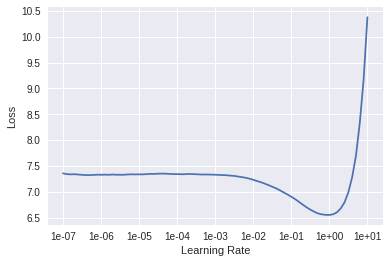

In [44]:
learn.lr_find(start_lr=1e-8, end_lr=1e2)
learn.recorder.plot()

Train the language model

In [45]:
learn = language_model_learner(data_lm, AWD_LSTM, 
                               drop_mult=0.5)
learn.fit_one_cycle(cyc_len=1, max_lr=1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
1,7.190032,6.640014,0.155134,00:14


In [46]:
learn.unfreeze()
learn.fit_one_cycle(cyc_len=20, max_lr=1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
1,6.549410,5.622668,0.185516,00:17
2,6.096427,5.224311,0.206994,00:17
3,5.739841,4.894814,0.219792,00:17
4,5.337419,4.383231,0.252505,00:17
5,4.931315,4.230371,0.262128,00:17
6,4.620509,4.111976,0.268452,00:17
7,4.376896,4.052958,0.271305,00:17
8,4.169637,4.031186,0.275248,00:17
9,3.990700,4.013226,0.278447,00:17
10,3.828390,4.015837,0.279663,00:17


In [0]:
learn.save_encoder('ft_enc')

** 5. Fine tunning the classifier **

In [0]:
data_clas = TextClasDataBunch.from_csv(CLAS_PATH, 'train.csv',
            vocab=data_lm.train_ds.vocab, min_freq=1, bs=32)

In [0]:
data_clas.save()

Train the classifier

In [0]:
learn = text_classifier_learner(data_clas,AWD_LSTM, drop_mult=0.5)
learn.load_encoder('ft_enc')
learn.freeze()

Finding the learning rate

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


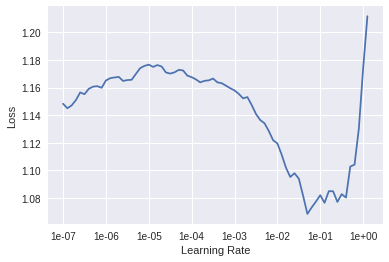

In [51]:
learn.lr_find(start_lr=1e-8, end_lr=1e2)
learn.recorder.plot()

In [52]:
learn.fit_one_cycle(cyc_len=1, max_lr=1e-3, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.857941,0.658632,0.729976,00:13


Gradually unfreeze the model and fine-tunning to increase accuracy

In [53]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-4,1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.731643,0.599670,0.758495,00:16


In [54]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(1e-5,5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.665715,0.581339,0.770631,00:24


In [55]:
learn.unfreeze()
learn.fit_one_cycle(4, slice(1e-5,1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
1,0.649433,0.584261,0.767597,00:32
2,0.643197,0.559006,0.777306,00:31
3,0.601770,0.557817,0.774879,00:31
4,0.603904,0.555568,0.773058,00:31


** 6. Testing the model **

In [0]:
testfile = 'test.csv'
test_csv = pd.read_csv(CLAS_PATH/testfile, names = ['target', 'tweet_test'])

In [0]:
test_csv = test_csv[['tweet_test','target']]

Testing the model

In [0]:
test_csv['prediction'] = test_csv['tweet_test'].apply(lambda row: str(learn.predict(row)[0]))

In [0]:
test_csv.to_csv('validation.csv')

The model will be tested by measuring the F1 score between prediction and target label

In [0]:
# F1 score test
from sklearn.metrics import f1_score

In [0]:
validate_csv = pd.read_csv('validation.csv')

In [63]:
print(f1_score(validate_csv['target'],validate_csv['prediction'],average='micro'))

0.7980349344978166


The f1 score shows 79.8% accuracy of the model validated with the test set. Therefore, the model does not reach the state of the art performance. This can be attributed to:

1.   The wiki103 language model is not a great fit for twitter sentiment. A language model pre-trained for twitter sentiment would be a better fit. The model struggle with neutral sentiment because the pretrained model deals best with strong sentiment such as negative or positive.
2.   Hyperparameter tunning such as learning rate, momentum, dropout parameters can be fine tunned further.

1.   Feature engineering such as tokenization, different neural net architechture can improve the performance. 

The model is 80% accurate, hence there is potential application for understanding customer reaction and satisfaction to airline events. Moreover, airline can gain insight into customer behaviour.



